# Copycat CNN and Knockoff Nets

This notebook does not work. I provided anyway to show the effort I put into the project.
I also tried some alternatives all using the adversarial robustness toolbox from trusted AI
https://github.com/Trusted-AI/adversarial-robustness-toolbox

The provided example by trusted AI itself did also not work, even unmodified. Probably through Tensorflow 1 and 2 interferance
(https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/model-stealing-demo.ipynb)

I was a bit disappointed that it did not work, since I used this GitHub to develop my Bachelor-Thesis Project about evasion attacks on tabular data.

## Installing Depenancies

In [ ]:
!pip install adversarial-robustness-toolbox --quiet

#!pip install pytorch==1.8.1 --quiet

     |████████████████████████████████| 1.1 MB 9.2 MB/s 
     |████████████████████████████████| 3.4 MB 53.0 MB/s 
     |████████████████████████████████| 25.3 MB 80 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import art

from art.classifiers import PyTorchClassifier

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy

from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Sequential
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
print(torch.__version__)

1.9.0+cu102


## Get the data via a data loader

In [ ]:
def get_data_loader(batch_size=5):
    """
    define data augmentation and return data loader with the cifar10 dataset loaded
    parameters:
        batch_size: size of the batch used for training and validation 
                    size of test batch is always 10
    Return:
        3 pytorch.dataloaders for easy batching of the dataset (train, validation and test)
    """

    # data augmentation
    """
    transform = transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    """
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
    test = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=False, transform=transform_test)
    
    n = len(trainset)
    print(n)
    train, val, steal =torch.utils.data.random_split(trainset, 
                                                    [int(n//100*50), int(n//100*30), int(n//100*20)],
                                                    generator=torch.Generator().manual_seed(42))
    
    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=0)
    steal_loader = torch.utils.data.DataLoader(dataset=steal, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader, val_loader, steal_loader, test_loader

In [ ]:
train_loader, val_loader, steal_loader, test_loader = get_data_loader(batch_size=5)

Files already downloaded and verified
50000


## Get a pretrained VGG Net and tune it Cifar Datasets

Both worked fine, but had there own problems on being integrated into the adversarial framework

In [ ]:
#model_name = 'vgg11_bn'
num_classes = 100
#feature_extract = True

In [ ]:
class VGG(nn.Module):

    def __init__(self, model_name='vgg11', num_classes='10', feature_extract=True, use_pretrained=True):
        """
        initalizes the version of VGG to be used and freezes the layers of the model and then add a new unfrozen head

        params:
            model_name(str): for example vgg16_bn for VGG-net with 16 weight layers and batch normalization
            num_classes(int): number of output classes (100 when using CIFAR100)
            feature_extract(bool): should the layers be frozen or not
            use_pretrained(bool): use the pretrained model weights or only the architecture itself
        """
        super().__init__()

        if model_name == 'vgg11':
            model = models.vgg11(pretrained=use_pretrained)
        elif model_name == 'vgg11_bn':
            model = models.vgg11_bn(pretrained=use_pretrained)
        elif model_name == 'vgg16':
            model = models.vgg16(pretrained=use_pretrained)
        elif model_name == 'vgg16_bn':
            model = models.vgg16_bn(pretrained=use_pretrained)
        elif model_name == 'vgg19':
            model = models.vgg19(pretrained=use_pretrained)
        elif model_name == 'vgg19_bn':
            model = models.vgg19_bn(pretrained=use_pretrained)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model
        
        
        self.set_parameter_requires_grad(feature_extract)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        self.model.to(self.device)
        self.feature_extract = feature_extract
        self.input_size = input_size
    
    def get_params_to_update(self):
        """ 
        prints the list of weights and bias that not frozen and will be tuned
        
        Gather the parameters to be optimized/updated in this run. If we are
        finetuning we will be updating all parameters. However, if we are
        doing feature extract method, we will only update the parameters
        that we have just initialized, i.e. the parameters with requires_grad
        is True.
        """

        params_to_update = self.model.parameters()
        print("\tWeights and Bias to be tuned:")
        if self.feature_extract:
            params_to_update = []
            for name,param in self.model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t\t",name)
        else:
            for name,param in self.model.named_parameters():
                if param.requires_grad == True:
                    print("\t\t",name)
                    
        return params_to_update
    
    def set_parameter_requires_grad(self, feature_extracting):
        """
        this freezes the layers in the network
        the new layer added later will automatically be unfrozen
        """
        if feature_extracting:
            for param in self.model.parameters():
                param.requires_grad = False
        

    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs=25, is_inception=False):
        since = time.time()

        val_acc_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        stop = False

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()  # Set model to training mode
                    datalaoder = train_loader
                else:
                    self.model.eval()   # Set model to evaluate mode
                    datalaoder = val_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if is_inception and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            outputs, aux_outputs = self.model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4*loss2
                        else:
                            outputs = self.model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # A simple addition to stop the training early
                    val_loss_history.append(loss)
                    if len(val_loss_history) > 3:
                        stop = (abs(val_loss_history[-3] - val_loss_history[-3]) +
                                abs(val_loss_history[-1] - val_loss_history[-2])) <= 0.001
                        print(abs(val_loss_history[-3] - val_loss_history[-3]) +
                                abs(val_loss_history[-1] - val_loss_history[-2]))
                if stop:
                    break

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        self.model.load_state_dict(best_model_wts)
        torch.save(self.model, 'model.pth')
        return self.model, val_acc_history

    def forward(self, x):
        return self.model(x)

    def evaluate(self, testloader):
        """
        train_methode is written in a way that it can also directly be used as evaluation
        by calling it this way
        """
        _, acc = self.train_model('_', testloader, '_', '_', num_epochs=1, is_inception=False)
        return acc

    def load_model(self, path):
        self.model = torch.load(path)

## This is the code to train variant 1

In [ ]:
#model_obj = VGG(model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, use_pretrained=True)

In [ ]:
#model_obj.model

In [ ]:
# Now we finetune the model to get a descent classfication performance on it
#print("Original model training:")
#params_to_update = model_obj.get_params_to_update()

In [ ]:
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(params_to_update, lr=0.001)
#num_epochs = 5

In [ ]:
# Setup the loss fxn
#criterion = nn.CrossEntropyLoss()

In [ ]:
#model, hist = model_obj.train_model(train_loader, val_loader, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

In [ ]:
#model_obj.load_model('/content/drive/MyDrive/DHBW Vorlesungen/6. Semester/Daten für Projekte/model.pth')

In [ ]:
#model = model_obj.model

## Second Variant
Training own VGG11 on Cifar 100, loading the pretrained model was diffult in a way that ART could properly interact with it

Used for this pretraining was code from https://github.com/kuangliu/pytorch-cifar which was fitted for this usecasse

In [ ]:
'''
VGG11/13/16/19 in Pytorch.
https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
'''
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class Own_VGG(nn.Module):
    def __init__(self, vgg_name):
        super(Own_VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        # print(x.shape)
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = Own_VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

test()

torch.Size([2, 100])


In [ ]:
# Train the model, skipped after I trained and saved it once
#Own_VGG.train_model = VGG.train_model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Own_VGG('VGG11')
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
start_epoch = 1
num_epochs = 5

# Training
def train(epoch):
    if not (epoch % 10) or epoch == 1:
        print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if not (epoch % 10) or epoch == 1:
            print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total), end='\r')
    if not (epoch % 10):
        print()


def eval(epoch, best_acc, path):

    net.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if not (epoch % 10):
                print(batch_idx, len(val_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (eval_loss/(batch_idx+1), 100.*correct/total, correct, total), end='\r')

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        
        torch.save(state, path)
        best_acc = acc
    
    return best_acc

#path = '/content/drive/MyDrive/DHBW Vorlesungen/6. Semester/Daten für Projekte/own_vgg_model.pth'
path = '/content/drive/MyDrive/Daten für Projekte/own_vgg_model.pth'
if False:
    best_acc = 50
    for epoch in range(start_epoch, start_epoch+100):
        train(epoch)
        best_acc = eval(epoch, best_acc, path)
        scheduler.step()

if True:
    net.load_state_dict(torch.load(path)['net'])
    #net.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['net'])

In [ ]:
model = net

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


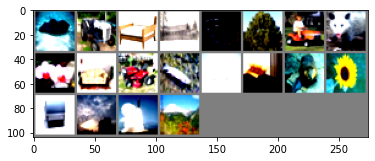

GroundTruth:  tensor(67) tensor(89) tensor(20) tensor(37)


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(5)))

# Start off the Model stealing

At this point we have a trained model, which we can try to steal

In [ ]:
sample = iter(test_loader)
input_shape = next(sample)[0].shape

In [ ]:
classifier_original = PyTorchClassifier(model,
                                        loss=nn.CrossEntropyLoss(),
                                        input_shape=input_shape,
                                        clip_values=(0, 1),
                                        nb_classes=100)

In [ ]:
len_steal = 250

In [ ]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

In [ ]:
# Eval Method from pytorch.org fitted to this purpose
def evaluate(self, images, labels):
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        
        # calculate outputs by running images through the network
        #images = images.to(device)
        outputs = self._model(images)
        #print(type(outputs), outputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs[0].data, 1)
        total += labels.size(0)
        labels = labels.to(device)
        #print(predicted.shape, labels.shape)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}')
    return 100 * correct / total

In [ ]:
# Modify the ART class for pytorch to eval the stolen model
PyTorchClassifier.evaluate = evaluate

# This cell had some weird bugs I wasnt able to fix

In [ ]:
for name, attack in attack_catalogue.items():
    model_stolen =  Own_VGG('VGG11')

    for idx, (test_set_x, test_set_y) in enumerate(steal_loader):
        
        len_steal = int(len(test_set_x)//2)
        print(len_steal)
        print(test_set_x.shape)
        indices = np.random.permutation(len_steal)
        x_steal = test_set_x[indices[:len_steal]]
        y_steal = test_set_y[indices[:len_steal]]
        x_test = test_set_x[indices[len_steal:]]
        y_test = test_set_y[indices[len_steal:]]
        print(x_test.shape)

            
        if idx == 0:
            classifier_stolen = PyTorchClassifier(model_stolen, loss=criterion, optimizer=optimizer,
                                            input_shape=x_steal.shape, nb_classes=100,
                                            clip_values=(0, 1))
        else:
            pass
        
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        #TODO add a function to PytorchClassifier and let it return a evalutation
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        try:
            acc = classifier_stolen.evaluate(x_test, y_test)
            print(name, ":", acc)
            results.append((name, len_steal, acc))
        except:
            print(x_test.shape)

# Standard Plotting functionality from the example

In [ ]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [ ]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

In [ ]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()